# From Dice Rolls to Image Generation: Langevin Sampling in Practice

---

In the blogpost we built intuition for how diffusion models work by connecting three ideas:

1. **Sampling from distributions** -- starting with dice rolls
2. **Langevin Sampling** -- using a score function + noise to sample from *any* distribution
3. **Diffusion models** -- learning the score function from data when we don't have an analytical expression

This notebook lets you **run and visualize** each of those ideas. By the end you'll have:

- Implemented Langevin Sampling from scratch
- Sampled from uniform, bimodal, and ring-shaped distributions
- Built a dice roll generator using only Gaussian noise
- Seen how noise and step size affect sample quality
- Trained a tiny score network on 2D data (the bridge to real diffusion models)

## 0. Setup

We only need NumPy and Matplotlib -- keeping things minimal so the math stays front and center.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','ieee'])

np.random.seed(42)

plt.rcParams.update({
    'figure.figsize': (10, 4),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
})

print("Ready to go!")

Ready to go!


## 1. Quick Review: PMF and PDF

Before diving into sampling algorithms, let's visualize the two flavors of probability we'll work with.

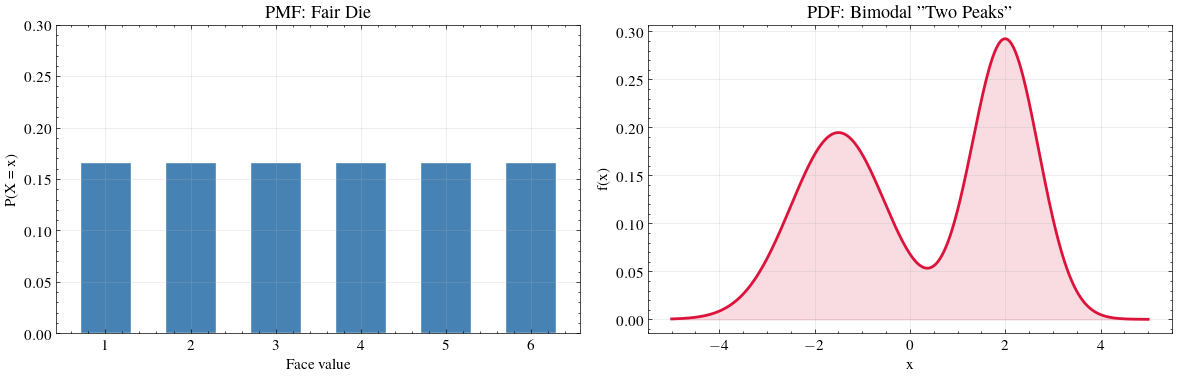

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# PMF of a fair die
faces = np.arange(1, 7)
probs = np.ones(6) / 6
axes[0].bar(faces, probs, color='steelblue', edgecolor='white', width=0.6)
axes[0].set_ylim(0, 0.3)
axes[0].set_xlabel('Face value')
axes[0].set_ylabel('P(X = x)')
axes[0].set_title('PMF: Fair Die')
axes[0].set_xticks(faces)

# PDF of a bimodal distribution
x = np.linspace(-5, 5, 500)
pdf = 0.4 * np.exp(-0.5 * (x + 1.5)**2) + 0.6 * np.exp(-0.5 * ((x - 2) / 0.7)**2)
pdf /= np.trapezoid(pdf, x)

axes[1].plot(x, pdf, 'crimson', lw=2)
axes[1].fill_between(x, pdf, alpha=0.15, color='crimson')
axes[1].set_xlabel('x')
axes[1].set_ylabel('f(x)')
axes[1].set_title('PDF: Bimodal "Two Peaks"')

plt.tight_layout()
plt.show()

## 2. The Score Function -- Intuition

The **score function** is the key ingredient of Langevin Sampling. It's defined as:

$$F(\mathbf{x}) = \nabla_{\mathbf{x}} \log p(\mathbf{x})$$

It tells us: *"from where I am right now, which direction increases the probability the fastest?"*

Let's visualize it for our bimodal distribution. Notice how:
- Arrows **point toward** the peaks
- Arrows are **longer** far from the peaks (strong pull) and **shorter** near them
- The $\log$ amplifies the gradient in low-density regions

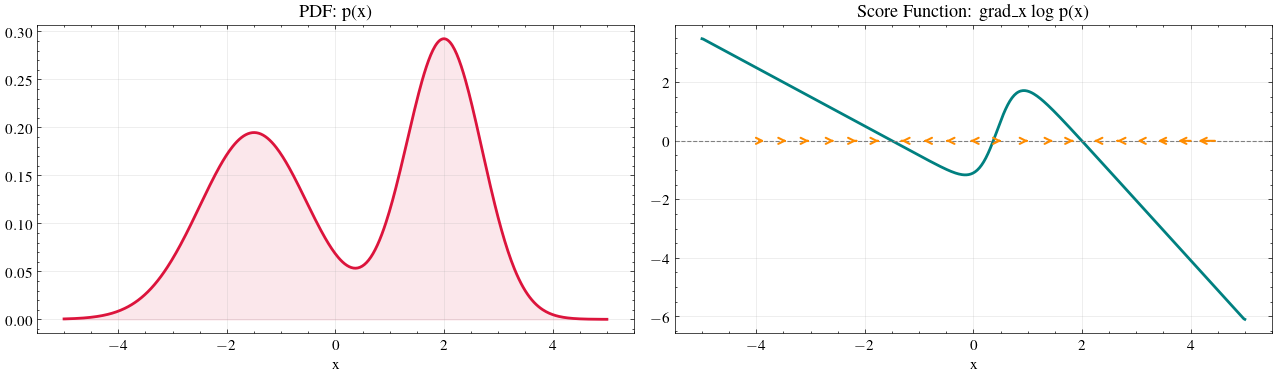

In [4]:
x = np.linspace(-5, 5, 500)
pdf = 0.4 * np.exp(-0.5 * (x + 1.5)**2) + 0.6 * np.exp(-0.5 * ((x - 2) / 0.7)**2)
pdf /= np.trapezoid(pdf, x)

log_pdf = np.log(pdf + 1e-10)
score = np.gradient(log_pdf, x)

fig, axes = plt.subplots(1, 2, figsize=(13, 4), dpi=100)

axes[0].plot(x, pdf, 'crimson', lw=2)
axes[0].fill_between(x, pdf, alpha=0.1, color='crimson')
axes[0].set_title('PDF: p(x)')
axes[0].set_xlabel('x')

axes[1].plot(x, score, 'teal', lw=2)
axes[1].axhline(0, color='gray', lw=0.8, ls='--')
axes[1].set_title('Score Function: grad_x log p(x)')
axes[1].set_xlabel('x')

# Add direction arrows
x_arrows = np.linspace(-4, 4.5, 20)
score_arrows = np.interp(x_arrows, x, score)
for xi, si in zip(x_arrows, score_arrows):
    axes[1].annotate('', xy=(xi + 0.08 * si, 0), xytext=(xi, 0),
                     arrowprops=dict(arrowstyle='->', color='darkorange', lw=1.5))

plt.tight_layout()
plt.show()

> **Key insight:** the score function has zeros exactly at the peaks of the distribution. Points to the left of a peak have positive score (move right), points to the right have negative score (move left).

## 3. Why the Logarithm Matters

The blogpost mentions that $\log$ amplifies gradients in low-density regions. Let's compare $\nabla_x p(x)$ vs. $\nabla_x \log p(x)$.

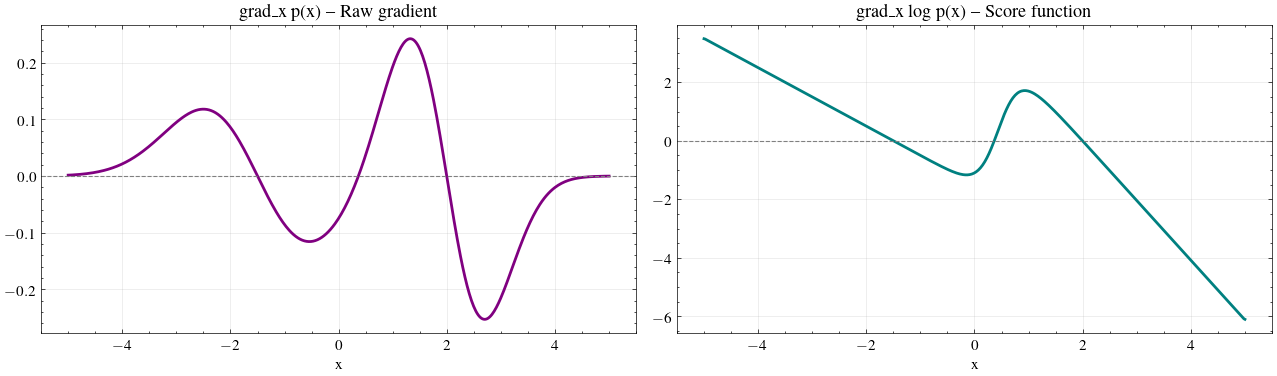

Notice how the raw gradient (left) nearly vanishes in the tails (|x| > 3),
while the score function (right) still has strong signal there.
Without the log, Langevin samples starting in low-density regions would barely move.


In [5]:
x = np.linspace(-5, 5, 500)
pdf = 0.4 * np.exp(-0.5 * (x + 1.5)**2) + 0.6 * np.exp(-0.5 * ((x - 2) / 0.7)**2)
pdf /= np.trapezoid(pdf, x)

grad_p = np.gradient(pdf, x)
grad_log_p = np.gradient(np.log(pdf + 1e-10), x)

fig, axes = plt.subplots(1, 2, figsize=(13, 4), dpi=100)

axes[0].plot(x, grad_p, 'purple', lw=2)
axes[0].axhline(0, color='gray', lw=0.8, ls='--')
axes[0].set_title('grad_x p(x) -- Raw gradient')
axes[0].set_xlabel('x')

axes[1].plot(x, grad_log_p, 'teal', lw=2)
axes[1].axhline(0, color='gray', lw=0.8, ls='--')
axes[1].set_title('grad_x log p(x) -- Score function')
axes[1].set_xlabel('x')

plt.tight_layout()
plt.show()

print("Notice how the raw gradient (left) nearly vanishes in the tails (|x| > 3),")
print("while the score function (right) still has strong signal there.")
print("Without the log, Langevin samples starting in low-density regions would barely move.")

## 4. Langevin Sampling -- Starting Simple with Uniform [0, 1]

The Langevin update rule is:

$$x_{t+1} = x_t + \epsilon \, F(x_t) + \sqrt{2\epsilon} \; z_t, \qquad z_t \sim \mathcal{N}(0, 1)$$

For a uniform distribution on $[0, 1]$, the score $F(x) = 0$ inside the interval. To keep samples from drifting outside, we add **potential walls** -- a restoring force that pushes samples back in.

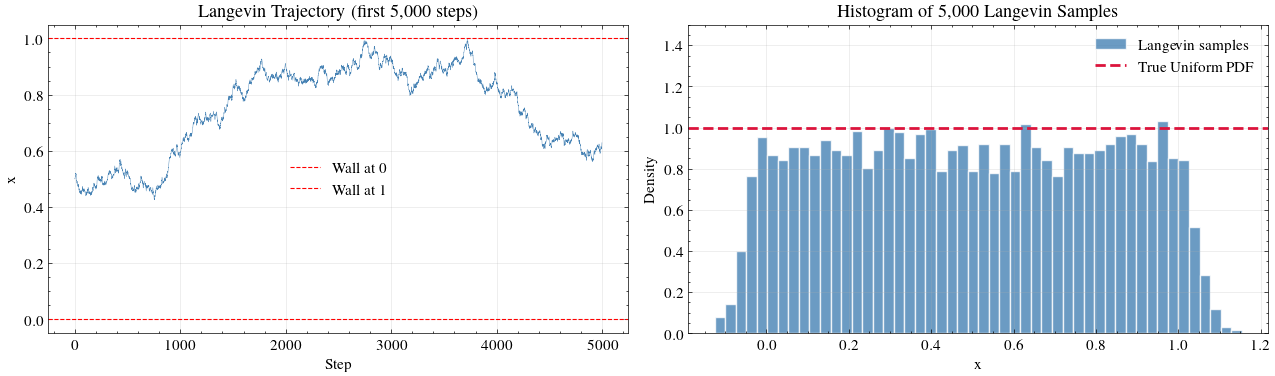

In [6]:
def F_uniform(x, a=0.0, b=1.0, k=500.0):
    """Score function for Uniform[a, b] with wall potentials."""
    if x < a:
        return -k * (x - a)
    elif x > b:
        return -k * (x - b)
    else:
        return 0.0

def langevin_sample(score_fn, n_steps=1000000, eps=1e-5, x0=0.5):
    """Run Langevin dynamics and return the final sample + trajectory."""
    x = x0
    trajectory = [x]
    for _ in range(n_steps):
        z = np.random.normal(0, 1)
        x = x + eps * score_fn(x) + np.sqrt(2 * eps) * z
        trajectory.append(x)
    return x, np.array(trajectory)

# Generate one trajectory to visualize
_, traj = langevin_sample(F_uniform, n_steps=30000, eps=1e-5)

fig, axes = plt.subplots(1, 2, figsize=(13, 4), dpi=100)

# Trajectory
axes[0].plot(traj[:5000], lw=0.3, color='steelblue')
axes[0].axhline(0, color='red', ls='--', lw=0.8, label='Wall at 0')
axes[0].axhline(1, color='red', ls='--', lw=0.8, label='Wall at 1')
axes[0].set_title('Langevin Trajectory (first 5,000 steps)')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('x')
axes[0].legend()

# Generate many samples
samples_uniform = np.array([
    langevin_sample(F_uniform, n_steps=30000, eps=1e-5)[0]
    for _ in range(5000)
])

axes[1].hist(samples_uniform, bins=50, density=True, color='steelblue',
             edgecolor='white', alpha=0.8, label='Langevin samples')
axes[1].axhline(1.0, color='crimson', ls='--', lw=2, label='True Uniform PDF')
axes[1].set_ylim(0, 1.5) 
axes[1].set_title('Histogram of 5,000 Langevin Samples')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Building a Dice Roll Generator

Now comes the payoff from the blogpost: we take our uniform $[0, 1]$ samples and threshold them into dice faces. The full pipeline is:

$$\text{Gaussian noise} \xrightarrow{\text{Langevin}} \text{Uniform}[0,1] \xrightarrow{\text{threshold}} \text{Dice face}$$

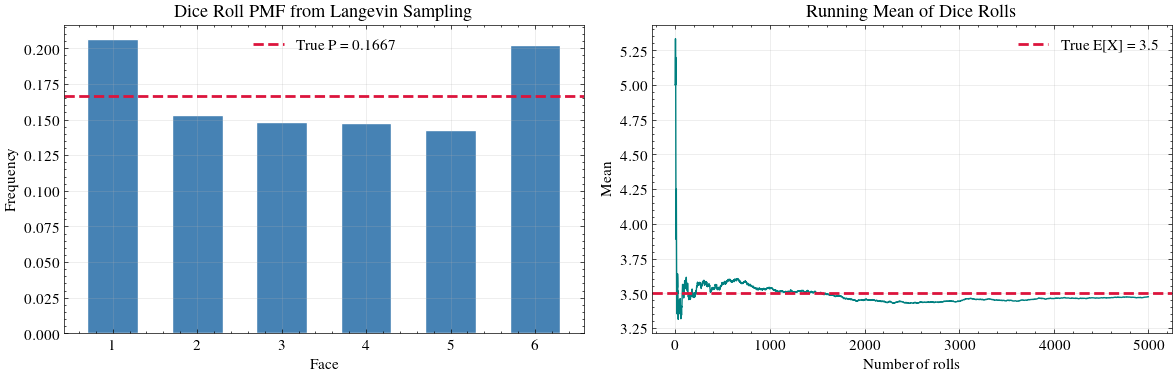

Empirical mean: 3.475  (expected: 3.500)
Empirical std:  1.815  (expected: 1.708)


In [7]:
def uniform_to_dice(u):
    """Convert a Uniform[0,1] sample to a dice face {1..6}."""
    return int(np.clip(np.ceil(u * 6), 1, 6))

dice_rolls = np.array([uniform_to_dice(s) for s in samples_uniform])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# Empirical PMF
faces, counts = np.unique(dice_rolls, return_counts=True)
freq = counts / counts.sum()
axes[0].bar(faces, freq, color='steelblue', edgecolor='white', width=0.6)
axes[0].axhline(1/6, color='crimson', ls='--', lw=2, label=f'True P = {1/6:.4f}')
axes[0].set_title('Dice Roll PMF from Langevin Sampling')
axes[0].set_xlabel('Face')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(1, 7))
axes[0].legend()

# Cumulative convergence
n = len(dice_rolls)
running_mean = np.cumsum(dice_rolls) / np.arange(1, n + 1)
axes[1].plot(running_mean, color='teal', lw=1)
axes[1].axhline(3.5, color='crimson', ls='--', lw=2, label='True E[X] = 3.5')
axes[1].set_title('Running Mean of Dice Rolls')
axes[1].set_xlabel('Number of rolls')
axes[1].set_ylabel('Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Empirical mean: {dice_rolls.mean():.3f}  (expected: 3.500)")
print(f"Empirical std:  {dice_rolls.std():.3f}  (expected: {np.sqrt(35/12):.3f})")

## 6. Langevin Sampling from the Bimodal Distribution

Now let's tackle the two-peaks distribution from the blogpost. This time we *know* the analytical PDF, so we can compute the exact score function and verify our samples match.

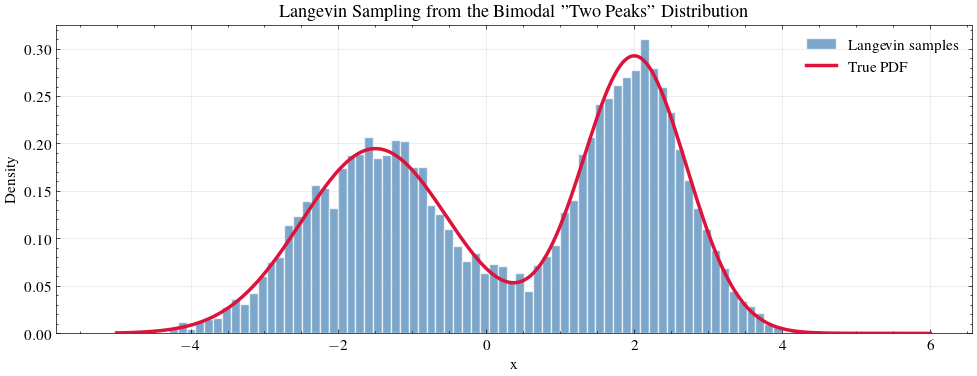

In [8]:
def p_twopeaks(x):
    """Unnormalized bimodal PDF."""
    return 0.4 * np.exp(-0.5 * (x + 1.5)**2) + 0.6 * np.exp(-0.5 * ((x - 2) / 0.7)**2)

def score_twopeaks(x):
    """Analytical score function for the bimodal distribution."""
    eps_safe = 1e-10
    px = p_twopeaks(x)
    dp = (0.4 * (-(x + 1.5)) * np.exp(-0.5 * (x + 1.5)**2)
        + 0.6 * (-(x - 2) / 0.7**2) * np.exp(-0.5 * ((x - 2) / 0.7)**2))
    return dp / (px + eps_safe)

# Langevin sampling
samples_bimodal = np.array([
    langevin_sample(score_twopeaks, n_steps=5000, eps=0.01, x0=np.random.randn())[0]
    for _ in range(10000)
])

# Plot
x_grid = np.linspace(-5, 6, 500)
true_pdf = np.array([p_twopeaks(xi) for xi in x_grid])
true_pdf /= np.trapezoid(true_pdf, x_grid)

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(samples_bimodal, bins=80, density=True, color='steelblue',
         edgecolor='white', alpha=0.7, label='Langevin samples')
plt.plot(x_grid, true_pdf, 'crimson', lw=2.5, label='True PDF')
plt.title('Langevin Sampling from the Bimodal "Two Peaks" Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## 7. What Happens Without Noise?

The blogpost emphasizes that noise is essential. Without it, Langevin dynamics degenerates into pure gradient ascent -- samples collapse to the peaks and we lose all diversity.

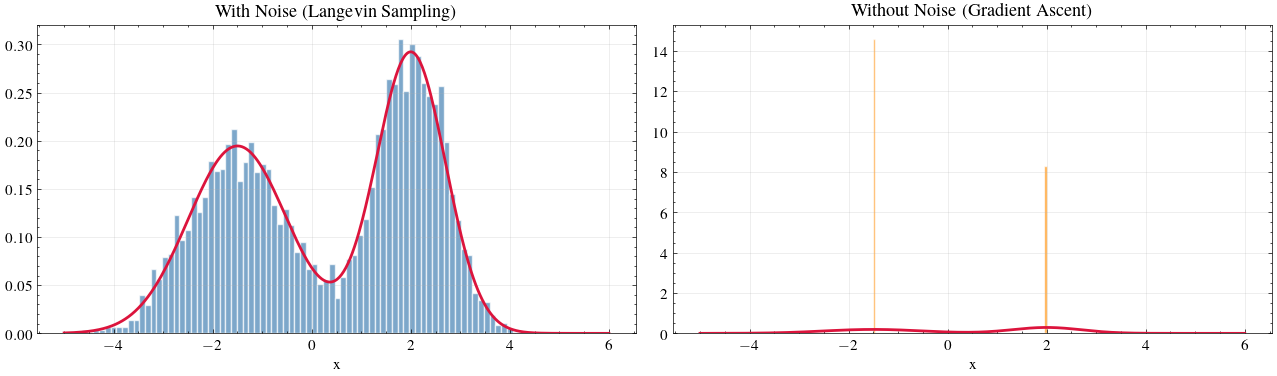

Without noise, samples collapse onto the two peaks as delta spikes.
No diversity -- this is what the blogpost warns about!


In [9]:
def langevin_no_noise(score_fn, n_steps=5000, eps=0.01, x0=0.0):
    """Langevin without the stochastic term."""
    x = x0
    for _ in range(n_steps):
        x = x + eps * score_fn(x)
    return x

# With noise
samples_with_noise = np.array([
    langevin_sample(score_twopeaks, n_steps=5000, eps=0.01, x0=np.random.randn())[0]
    for _ in range(5000)
])

# Without noise
samples_no_noise = np.array([
    langevin_no_noise(score_twopeaks, n_steps=5000, eps=0.01, x0=np.random.randn())
    for _ in range(5000)
])

fig, axes = plt.subplots(1, 2, figsize=(13, 4), dpi=100)

x_grid = np.linspace(-5, 6, 500)
true_pdf = np.array([p_twopeaks(xi) for xi in x_grid])
true_pdf /= np.trapezoid(true_pdf, x_grid)

axes[0].hist(samples_with_noise, bins=80, density=True, color='steelblue',
             edgecolor='white', alpha=0.7)
axes[0].plot(x_grid, true_pdf, 'crimson', lw=2)
axes[0].set_title('With Noise (Langevin Sampling)')
axes[0].set_xlabel('x')

axes[1].hist(samples_no_noise, bins=80, density=True, color='darkorange',
             edgecolor='white', alpha=0.7)
axes[1].plot(x_grid, true_pdf, 'crimson', lw=2)
axes[1].set_title('Without Noise (Gradient Ascent)')
axes[1].set_xlabel('x')

plt.tight_layout()
plt.show()

print("Without noise, samples collapse onto the two peaks as delta spikes.")
print("No diversity -- this is what the blogpost warns about!")

## 8. The Effect of Step Size $\epsilon$

Step size is a critical hyperparameter. Too small means samples don't explore enough. Too large means the dynamics become unstable.

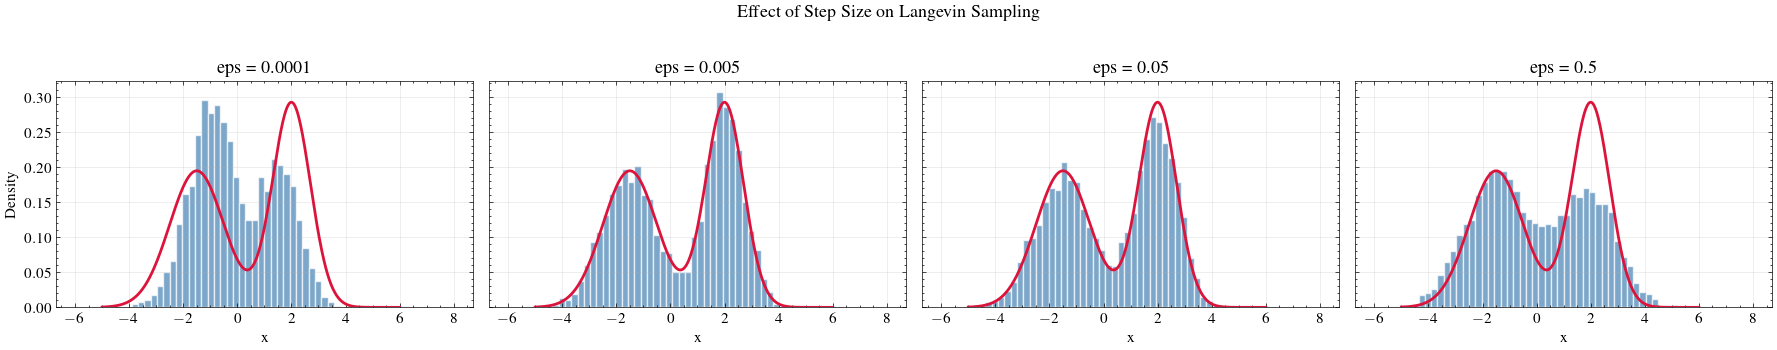

In [10]:
epsilons = [0.0001, 0.005, 0.05, 0.5]

fig, axes = plt.subplots(1, 4, figsize=(18, 3.5), sharey=True, dpi=100)

x_grid = np.linspace(-5, 6, 500)
true_pdf = np.array([p_twopeaks(xi) for xi in x_grid])
true_pdf /= np.trapezoid(true_pdf, x_grid)

for ax, eps in zip(axes, epsilons):
    samps = np.array([
        langevin_sample(score_twopeaks, n_steps=5000, eps=eps, x0=np.random.randn())[0]
        for _ in range(5000)
    ])
    ax.hist(samps, bins=60, density=True, color='steelblue',
            edgecolor='white', alpha=0.7, range=(-6, 8))
    ax.plot(x_grid, true_pdf, 'crimson', lw=2)
    ax.set_title(f'eps = {eps}')
    ax.set_xlabel('x')

axes[0].set_ylabel('Density')
plt.suptitle('Effect of Step Size on Langevin Sampling', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 9. Going 2D: Sampling from a Ring Distribution

Real images live in *millions* of dimensions. We can't visualize that, but 2D is a great stepping stone. Let's sample from a ring-shaped distribution where the probability mass lives on a circle of radius R.

The score function now returns a **2D vector** at every point -- a true vector field.

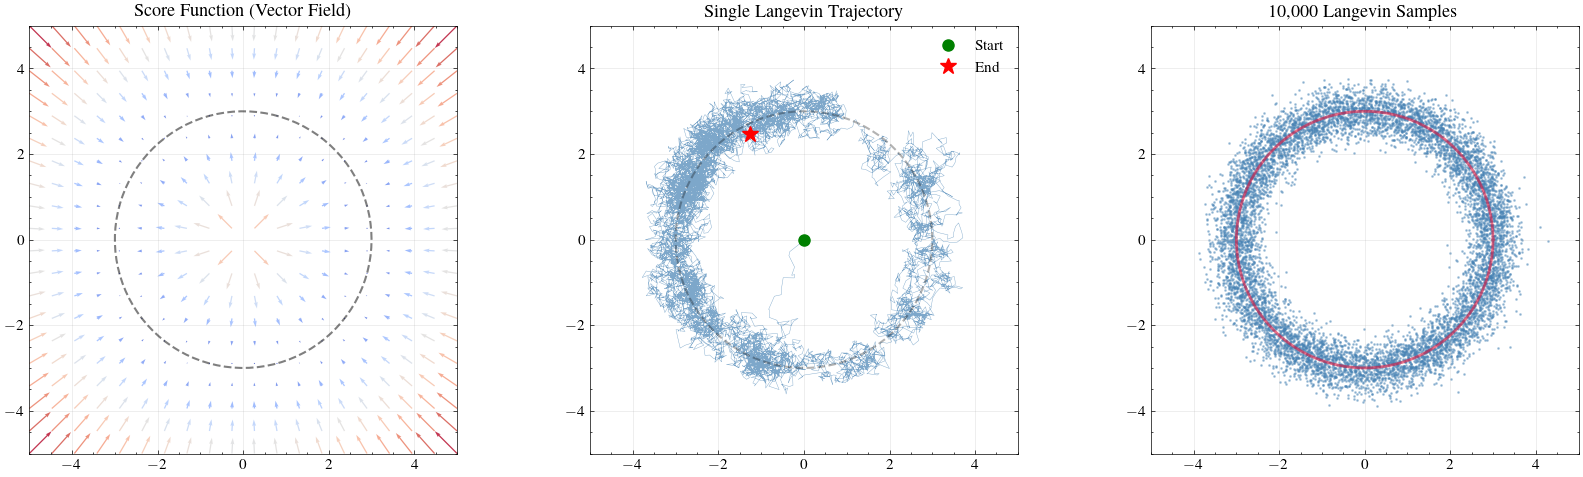

In [11]:
def score_ring(xy, R=3.0, sigma=0.3):
    """Score function for a ring distribution."""
    x, y = xy
    r = np.sqrt(x**2 + y**2) + 1e-10
    factor = -(r - R) / (sigma**2)
    return np.array([factor * x / r, factor * y / r])

def langevin_2d(score_fn, n_steps=10000, eps=0.005, x0=None):
    """Two-dimensional Langevin sampling."""
    xy = x0 if x0 is not None else np.random.randn(2)
    trajectory = [xy.copy()]
    for _ in range(n_steps):
        z = np.random.randn(2)
        xy = xy + eps * score_fn(xy) + np.sqrt(2 * eps) * z
        trajectory.append(xy.copy())
    return xy, np.array(trajectory)

fig, axes = plt.subplots(1, 3, figsize=(17, 5), dpi=100)

# Score vector field
grid_pts = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(grid_pts, grid_pts)
U = np.zeros_like(X)
V = np.zeros_like(Y)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        s = score_ring(np.array([X[i, j], Y[i, j]]))
        U[i, j], V[i, j] = s

axes[0].quiver(X, Y, U, V, np.sqrt(U**2 + V**2), cmap='coolwarm', alpha=0.8)
theta = np.linspace(0, 2*np.pi, 100)
axes[0].plot(3*np.cos(theta), 3*np.sin(theta), 'k--', lw=1.5, alpha=0.5)
axes[0].set_title('Score Function (Vector Field)')
axes[0].set_aspect('equal')
axes[0].set_xlim(-5, 5); axes[0].set_ylim(-5, 5)

# One trajectory
_, traj = langevin_2d(score_ring, n_steps=10000, eps=0.005, x0=np.array([0.0, 0.0]))
axes[1].plot(traj[:, 0], traj[:, 1], lw=0.3, color='steelblue', alpha=0.7)
axes[1].plot(traj[0, 0], traj[0, 1], 'go', ms=8, label='Start')
axes[1].plot(traj[-1, 0], traj[-1, 1], 'r*', ms=12, label='End')
axes[1].plot(3*np.cos(theta), 3*np.sin(theta), 'k--', lw=1.5, alpha=0.3)
axes[1].set_title('Single Langevin Trajectory')
axes[1].set_aspect('equal')
axes[1].set_xlim(-5, 5); axes[1].set_ylim(-5, 5)
axes[1].legend()

# Many samples
samples_ring = np.array([
    langevin_2d(score_ring, n_steps=10000, eps=0.005)[0]
    for _ in range(10000)
])

axes[2].scatter(samples_ring[:, 0], samples_ring[:, 1], s=1, alpha=0.4, color='steelblue')
axes[2].plot(3*np.cos(theta), 3*np.sin(theta), 'crimson', lw=2, alpha=0.6)
axes[2].set_title('10,000 Langevin Samples')
axes[2].set_aspect('equal')
axes[2].set_xlim(-5, 5); axes[2].set_ylim(-5, 5)

plt.tight_layout()
plt.show()

## 10. Learning the Score Function with a Neural Network

Here's where it all connects to diffusion models. In real applications we **don't know** the analytical PDF -- we only have *samples* (like images on the internet). So we train a neural network to **estimate the score function** from data.

This is called **score matching**, and it's the foundation of diffusion models.

We'll use a simple setup:
- **True distribution**: a mixture of 4 Gaussians in 2D (think of these as 4 "clusters of images")
- **Training data**: 10,000 samples from this mixture
- **Model**: a small neural network that takes a 2D point and predicts the 2D score vector

We'll implement this from scratch with just NumPy -- no PyTorch needed.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


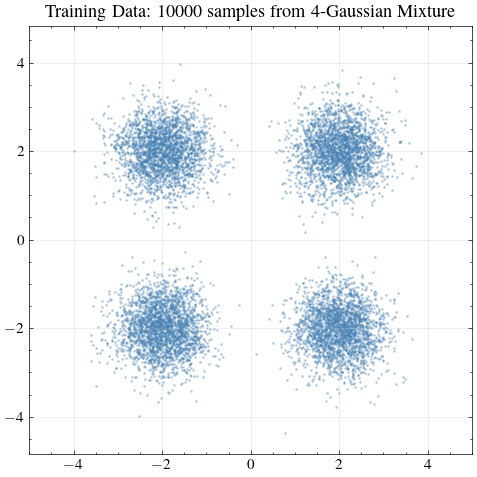

In [12]:
# Ground truth: Mixture of 4 Gaussians

means = np.array([[-2, -2], [-2, 2], [2, -2], [2, 2]], dtype=float)
sigma_mog = 0.5

n_train = 10000
components = np.random.randint(0, 4, n_train)
train_data = means[components] + sigma_mog * np.random.randn(n_train, 2)

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(train_data[:, 0], train_data[:, 1], s=1, alpha=0.3, color='steelblue')
plt.title(f'Training Data: {n_train} samples from 4-Gaussian Mixture')
plt.axis('equal')
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

### Training a Score Network via Denoising Score Matching

The key trick (from Pascal Vincent, 2011) is that instead of estimating the score of the data distribution directly, we add noise to the data and train the network to predict the score of the **noised** distribution. The training objective becomes:

$$\mathcal{L} = \mathbb{E}_{x \sim p_\text{data}} \mathbb{E}_{\tilde{x} \sim \mathcal{N}(x, \sigma^2 I)} \left\| s_\theta(\tilde{x}) - \frac{x - \tilde{x}}{\sigma^2} \right\|^2$$

The target $\frac{x - \tilde{x}}{\sigma^2}$ is just the direction pointing from the noised sample back to the clean sample -- which is exactly the score of the noised distribution!

This connects to the blogpost's point: **"the model learns to predict the noise, and this is equivalent to learning the score function."**

Epoch  20/1000  Loss: 196.3126
Epoch  40/1000  Loss: 198.9888
Epoch  60/1000  Loss: 194.6591
Epoch  80/1000  Loss: 195.8769
Epoch 100/1000  Loss: 196.7532
Epoch 120/1000  Loss: 196.2276
Epoch 140/1000  Loss: 193.6598
Epoch 160/1000  Loss: 194.8405
Epoch 180/1000  Loss: 192.8490
Epoch 200/1000  Loss: 195.8803
Epoch 220/1000  Loss: 194.9627
Epoch 240/1000  Loss: 192.6777
Epoch 260/1000  Loss: 197.2071
Epoch 280/1000  Loss: 190.8371
Epoch 300/1000  Loss: 194.2897
Epoch 320/1000  Loss: 192.6333
Epoch 340/1000  Loss: 195.7450
Epoch 360/1000  Loss: 194.0622
Epoch 380/1000  Loss: 193.1004
Epoch 400/1000  Loss: 191.7269
Epoch 420/1000  Loss: 193.3341
Epoch 440/1000  Loss: 187.6637
Epoch 460/1000  Loss: 192.0447
Epoch 480/1000  Loss: 194.6063
Epoch 500/1000  Loss: 194.6318
Epoch 520/1000  Loss: 192.6113
Epoch 540/1000  Loss: 194.4279
Epoch 560/1000  Loss: 194.8894
Epoch 580/1000  Loss: 193.0454
Epoch 600/1000  Loss: 191.4666
Epoch 620/1000  Loss: 191.0342
Epoch 640/1000  Loss: 190.8146
Epoch 66

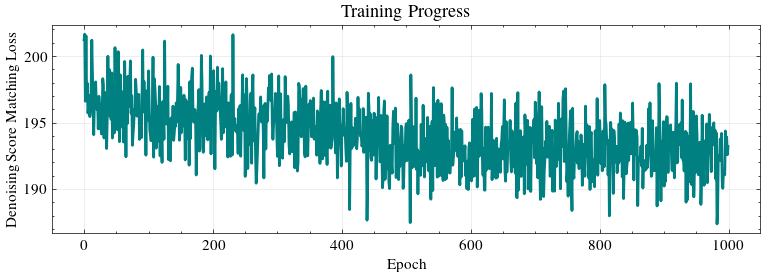

In [13]:
class ScoreNet:
    """Two-layer MLP: input(2) -> hidden(128) -> hidden(128) -> output(2)"""

    def __init__(self, hidden=128):
        self.W1 = np.random.randn(2, hidden) * np.sqrt(2.0 / 2)
        self.b1 = np.zeros(hidden)
        self.W2 = np.random.randn(hidden, hidden) * np.sqrt(2.0 / hidden)
        self.b2 = np.zeros(hidden)
        self.W3 = np.random.randn(hidden, 2) * np.sqrt(2.0 / hidden)
        self.b3 = np.zeros(2)

    def forward(self, x):
        self.x = x
        self.h1_pre = x @ self.W1 + self.b1
        self.h1 = np.maximum(0, self.h1_pre)
        self.h2_pre = self.h1 @ self.W2 + self.b2
        self.h2 = np.maximum(0, self.h2_pre)
        self.out = self.h2 @ self.W3 + self.b3
        return self.out

    def backward(self, grad_out, lr=1e-4):
        batch = grad_out.shape[0]
        gW3 = self.h2.T @ grad_out / batch
        gb3 = grad_out.mean(axis=0)
        grad_h2 = grad_out @ self.W3.T
        grad_h2 = grad_h2 * (self.h2_pre > 0)
        gW2 = self.h1.T @ grad_h2 / batch
        gb2 = grad_h2.mean(axis=0)
        grad_h1 = grad_h2 @ self.W2.T
        grad_h1 = grad_h1 * (self.h1_pre > 0)
        gW1 = self.x.T @ grad_h1 / batch
        gb1 = grad_h1.mean(axis=0)
        self.W3 -= lr * gW3; self.b3 -= lr * gb3
        self.W2 -= lr * gW2; self.b2 -= lr * gb2
        self.W1 -= lr * gW1; self.b1 -= lr * gb1

# Training
model = ScoreNet(hidden=128)
noise_sigma = 0.1
batch_size = 256
n_epochs = 1000
lr = 3e-4
losses = []

for epoch in range(n_epochs):
    perm = np.random.permutation(n_train)
    epoch_loss = 0
    n_batches = 0

    for i in range(0, n_train - batch_size, batch_size):
        idx = perm[i:i+batch_size]
        x_clean = train_data[idx]
        noise = noise_sigma * np.random.randn(batch_size, 2)
        x_noisy = x_clean + noise

        # Target: direction from noisy back to clean
        target = (x_clean - x_noisy) / (noise_sigma**2)

        pred = model.forward(x_noisy)
        diff = pred - target
        loss = np.mean(np.sum(diff**2, axis=1))
        epoch_loss += loss
        n_batches += 1

        grad = 2 * diff / batch_size
        model.backward(grad * batch_size, lr=lr)

    avg_loss = epoch_loss / n_batches
    losses.append(avg_loss)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}/{n_epochs}  Loss: {avg_loss:.4f}")

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(losses, color='teal', lw=2)
plt.xlabel('Epoch')
plt.ylabel('Denoising Score Matching Loss')
plt.title('Training Progress')
plt.tight_layout()
plt.show()

### Generating Samples with the Learned Score Function

Now we use our trained network as the score function inside Langevin Sampling -- exactly like a diffusion model does at inference time.

Generating samples with learned score function...
Done!


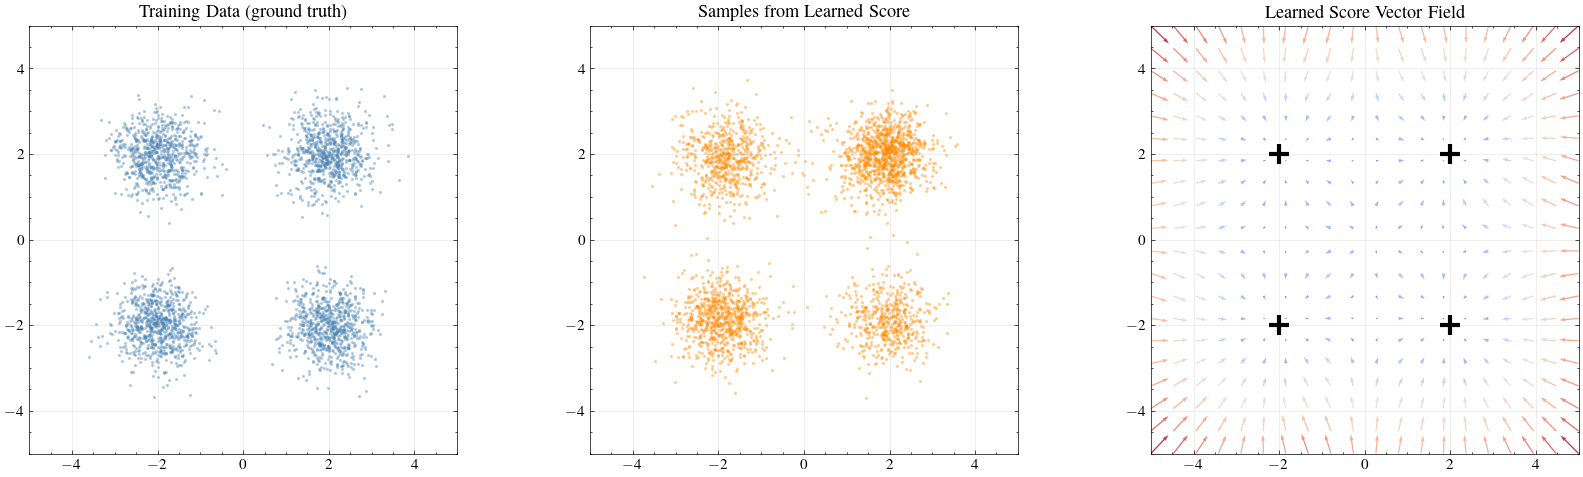

In [14]:
def langevin_learned(model, n_steps=10000, eps=0.005, x0=None):
    """Langevin sampling using the learned score network."""
    xy = x0 if x0 is not None else np.random.randn(2) * 3
    for _ in range(n_steps):
        z = np.random.randn(2)
        score = model.forward(xy.reshape(1, 2)).flatten()
        xy = xy + eps * score + np.sqrt(2 * eps) * z
    return xy

print("Generating samples with learned score function...")
learned_samples = np.array([
    langevin_learned(model, n_steps=10000, eps=0.005)
    for _ in range(3000)
])
print("Done!")

fig, axes = plt.subplots(1, 3, figsize=(17, 5), dpi=100)

# Training data
axes[0].scatter(train_data[:3000, 0], train_data[:3000, 1], s=2, alpha=0.3, c='steelblue')
axes[0].set_title('Training Data (ground truth)')
axes[0].set_xlim(-5, 5); axes[0].set_ylim(-5, 5)
axes[0].set_aspect('equal')

# Learned samples
axes[1].scatter(learned_samples[:, 0], learned_samples[:, 1], s=2, alpha=0.3, c='darkorange')
axes[1].set_title('Samples from Learned Score')
axes[1].set_xlim(-5, 5); axes[1].set_ylim(-5, 5)
axes[1].set_aspect('equal')

# Learned vector field
grid_pts = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(grid_pts, grid_pts)
points = np.stack([X.ravel(), Y.ravel()], axis=1)
scores_pred = model.forward(points)
U = scores_pred[:, 0].reshape(X.shape)
V = scores_pred[:, 1].reshape(X.shape)

axes[2].quiver(X, Y, U, V, np.sqrt(U**2 + V**2), cmap='coolwarm', alpha=0.8)
for m in means:
    axes[2].plot(m[0], m[1], 'k+', ms=15, mew=3)
axes[2].set_title('Learned Score Vector Field')
axes[2].set_xlim(-5, 5); axes[2].set_ylim(-5, 5)
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

## 11. The Bridge to Real Diffusion Models

What we just did is the **core loop** of a diffusion model:

| This notebook | Real diffusion model |
|---|---|
| 2D Gaussian mixture | Distribution of natural images |
| 10K training points | Millions of images from the internet |
| 2-layer MLP | U-Net or Transformer |
| Single noise level | Multiple noise levels (annealed) |
| Langevin sampling | DDPM / DDIM / SDE samplers |

The key ideas are identical:

1. **We don't know p(x)** -- we only have samples
2. **We train a model to estimate the score function** from noised data
3. **We generate new samples** by starting from noise and following the learned score

The main additions in real diffusion models are:
- **Annealed noise schedules** -- training the score at *many* noise levels and gradually reducing noise during sampling
- **Much larger networks** -- U-Nets or Vision Transformers instead of tiny MLPs
- **Conditioning** -- text prompts, class labels, etc. that guide the score function

## Summary

We've traveled from dice rolls to neural score estimation, covering the complete conceptual pipeline of diffusion models:

1. **Sampling is hard** -- even for a uniform distribution, you need clever algorithms
2. **Langevin Sampling** uses a score function + noise to generate samples from any distribution
3. **The score function** is a vector field pointing toward high-probability regions
4. **Noise is essential** -- without it, samples collapse and diversity is lost
5. **Neural networks can learn the score** from data alone (denoising score matching)
6. **This is exactly what diffusion models do** -- just scaled up to millions of dimensions

The deep insight: diffusion models aren't just "denoisers." They're **probability samplers** that combine a learned score function with controlled stochastic dynamics to explore the space of possible images.